In [2]:
#-------------------------------------------------------
# demo code to perfrom maximum likelihood analysis of
# radial velociy measurements between a spectrum and a
# given template, drawn from the BOSZ models
#
# Alex Szalay, 2021-10-05
#-------------------------------------------------------
import numpy as np
import scipy as sp
import os
import collections
import copy
import time
import urllib
import bz2
import h5py

import matplotlib.pyplot as plt
from scipy import stats
from numpy import linalg
%matplotlib inline

In [3]:
NORM_PATH = "/scratch/ceph/szalay/swei20/AE/norm_flux.h5"
with h5py.File(NORM_PATH, 'r') as f:
    para = f['para'][()]

In [4]:
MH    = para[:,0]
Teff  = para[:,1]
logG  = para[:,2]
CH    = para[:,3]
AH = para[:,4]
uM = np.unique(MH)
uT = np.unique(Teff)
uG = np.unique(logG)
uC = np.unique(CH)
uA = np.unique(AH)

if (1==1):
    print('Teff:',uT)
    print('logG:',uG)
    print('M/H :',uM)
    print('ALP :',uA)
    print('C/H :',uC)

Teff: [ 3500.  3750.  4000.  4250.  4500.  4750.  5000.  5250.  5500.  5750.
  6000.  6250.  6500.  6750.  7000.  7250.  7500.  7750.  8000.  8250.
  8500.  8750.  9000.  9250.  9500.  9750. 10000. 10250. 10500. 10750.
 11000. 11250. 11500. 11750. 12000. 12500. 13000. 13500. 14000. 14500.
 15000. 15500. 16000. 16500. 17000. 17500. 18000. 18500. 19000. 19500.
 20000. 21000. 22000. 23000. 24000. 25000. 26000. 27000. 28000. 29000.
 30000. 31000. 32000. 33000. 34000. 35000.]
logG: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
M/H : [-2.5  -2.25 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25
  0.5   0.75]
ALP : [-0.25  0.    0.25  0.5 ]
C/H : [-0.5  -0.25  0.    0.25  0.5 ]


In [5]:
#------------------------------------------------
# set working directory (change it to your own)
#------------------------------------------------
# os.chdir('/home/idies/workspace/Storage/szalay/persistent/PFS/RV')

#----------------------------------
# read all the parameter data
#----------------------------------
DATAPATH = "/home/swei20/LV/data/"
#--------------------------------------
# read the raw Mauna Kea sky spectrum
#--------------------------------------
sky = np.genfromtxt(DATAPATH+'skybg_50_10.csv', delimiter=',')
sky[:,0]= 10*sky[:,0]

#-----------------------------------
# create subdirectory for figures
#-----------------------------------
if (not os.path.isdir('./figs')):
    os.mkdir('./figs')
    

In [6]:
#-----------------------------------------------------------------------------------
# generate the url and the pathname from the parameters to download the spectrum
#-----------------------------------------------------------------------------------
def fmt(x):
    y = np.round(np.abs(10*x)+0.2).astype(np.int32)
    z = '{:+03.0f}'.format(y).replace('+','p')
    if (np.sign(x)<0):
        z = z.replace('p','m')
    return z

def fmn(x):    
    return '{:02d}'.format(np.floor(x).astype(np.int32))

def ffm(x):
    return '{:+4.2f}'.format(x)   
    
def getfilename(m,c,a,t,g,R):
    #---------------------------------------
    # get the long filename for the website
    #---------------------------------------
    fname = 'am'+fmt(m)+'c'+fmt(c)+'o'+fmt(a)+'t'+fmn(t)+'g'\
        +fmn(10*g)+'v20modrt0b'+'{:d}'.format(R)+'rs.asc.bz2'
    return fname

def getname(m,c,a,t,g):
    #----------------------------------
    # get short name for the spectrum
    #----------------------------------
    fname = 'T'+fmn(t)+'G'+fmn(10*g)+'M'+fmt(m)+'A'+fmt(a)+'C'+fmt(c)
    return fname
    
def geturl(m,c,a,t,g,R):
    #----------------------------------------
    # build the url for the STScI site
    #----------------------------------------    
    url = 'https://archive.stsci.edu/missions/hlsp/bosz/ascii/insbroad_'+'{:06d}'.format(R)+'/'
    url = url + 'metal_'+ffm(m) + '/carbon_'+ffm(c) + '/alpha_'+ffm(a)
    url = url + '/'+ getfilename(m,c,a,t,g,R)
    return url

#url = 'https://archive.stsci.edu/missions/hlsp/bosz/ascii/insbroad_020000/metal_-1.00/carbon_+0.00/alpha_+0.25/amm10cp00op03t10500g25v20modrt0b20000rs.asc.bz2'

#--------------------------
# get the data from a url
#--------------------------
def download_url(url, root, filename=None):
    """Download a file from a url and place it in root.
    Args:
        url (str): URL to download file from
        root (str): Directory to place downloaded file in
        filename (str, optional): Name to save the file under. If None, use the basename of the URL
    """
    root = os.path.expanduser(root)
    if not filename:
        filename = os.path.basename(url)
    fpath = os.path.join(root, filename)

    os.makedirs(root, exist_ok=True)

    try:
        #print('Downloading ' + url + ' to ' + fpath)
        urllib.request.urlretrieve(url, fpath)
    except (urllib.error.URLError, IOError) as e:
        if url[:5] == 'https':
            url = url.replace('https:', 'http:')
            print('Failed download. Trying https -> http instead.'
                    ' Downloading ' + url + ' to ' + fpath)
            urllib.request.urlretrieve(url, fpath)

def getSpectrum(m,c,a,t,g):
    #-----------------------------------------------------------
    # get a spectrum given the 5 parameter values
    # Input:
    #   m : M/H
    #   c : C/H
    #   a : ALPHA/H
    #   t : Teff
    #   g : log g
    # Output:
    #   o[:,0] is the wavelength in \AA
    #   o[:,1] is the flux
    #   o[:,2] is the theoretical envelope
    #-----------------------------------------------------------
    # The spectrum extends a bit beyond the MR range
    #     6250 A < lambda < 9750 A
    # If the parameter values are not on the grid, returns an 
    # empty vector and writes an error message
    #-----------------------------------------------------------
    # set the resolution in the BOSZ convention, 
    # corresponding to R=100,000
    #-----------------------------------------------------------
    R = 50000
    #------------------------------------------------------
    # first check if the values are a valid grid location
    #------------------------------------------------------
    if (~isValidGrid(m,c,a,t,g)):
        print('Parameters are not on the grid')
        return np.zeros((1,3))    
    #--------------------------------------
    # fbuild the url and fetch the data
    #--------------------------------------
    url = geturl(m,c,a,t,g,R)
    print(url)
    download_url(url,'tmp/','test.bz2')
    #
    filepath    = 'tmp/test.bz2'
    newfilepath = 'tmp/test.txt'
    #--------------------------
    # unzip the spectrum
    #--------------------------
    with open(newfilepath, 'w') as new_file, bz2.BZ2File(filepath, 'rb') as file:
        data = file.read().decode("utf-8") 
        new_file.write(data)
    d = np.genfromtxt(newfilepath, delimiter=' ')
    #----------------------------------------------------------------------
    # select the wavelength range for the medium resolution spectrograph
    #----------------------------------------------------------------------
    iw = (d[:,0]>=6250) & (d[:,0]<=9750)
    o  = d[iw,:]
    #
    return o


In [7]:
def isValidGrid(m,c,a,t,g):
    #----------------------------------------------------------
    # determine if the parameters are at a valid grid point
    #----------------------------------------------------------
    ix = (MH==m) & (CH==c) & (AH==a) & (Teff==t) & (logG==g)
    return ix.any()


In [8]:
#----------------------------------------------------------------------
# Basic bulding blocks for creating the spectra.
# These should be replaced with their proper PFS implementations.
# we are starting from BOSZ spectra with R=50,000, corresponding
# to lambda/dlambda = 100,000 per pixel.  We need to reduce this 
# to dlambda~0.4A, which is lambda/dlambda = 20,000, i.e. 5 h-pixels
# per m-pixel. One h-pixel is 3 km/s, and one m-pixel is 15 km/s.
#----------------------------------------------------------------------

def resampleSpec(spec, step=5):
    #-----------------------------------------------------
    # resample the spectrum by a factor step
    #-----------------------------------------------------
    c = np.cumsum(spec)
    b = list(range(1,spec.shape[0],step))
    db = np.diff(c[b])
    dd = (db/step)
    return dd

def resampleWave(wave,step=5):
    #-----------------------------------------------------
    # resample the wavelengths by a factor step
    # output values are geometric mean of the boundaries.
    #-----------------------------------------------------
    w = np.cumsum(np.log(wave))
    b = list(range(1,wave.shape[0],step))
    db = np.diff(w[b])
    dd = (db/step)
    return np.exp(dd)

def resampleSky(sky, ww, step=5):
    #-----------------------------------------------------
    # resample the sky matching the spectrum
    #-----------------------------------------------------
    # get the breakpoints in lambda
    #--------------------------------
    b = list(range(1,ww.shape[0],step))
    ws = sky[:,0]
    cs = np.cumsum(sky[:,1])
    #---------------------------------------------------
    # interpolate the cumulative sky to the breakpoints
    #---------------------------------------------------
    f = sp.interpolate.interp1d(ws,cs, fill_value=0)
    sky_new = np.diff(f(ww[b]))
    return sky_new

def convolveSpec(spec,step=5):
    #---------------------------------------------------------
    # apply a line spread function to the h-pixel spectrum
    # with a width of 1.3 m-pixels. This is using the log(lambda) 
    # binning in hirez.
    #---------------------------------------------------------
    sg = 1.3
    #-----------------------------------
    # create resampled kernel by step
    # precompute the kernel, if there are many convolutions
    #-----------------------------------
    xx = np.linspace(-7*step, 7*step, 14*step+1)
    yy = np.exp(-0.5*xx**2/sg**2)/np.sqrt(2*np.pi*sg**2)
    fspec = np.convolve(spec,yy,'same')
    return fspec

def shiftSpec(ss, rv):
    #--------------------------------------------------
    # The radial velocity rv is given in km/sec units
    # This must be done at the hirez pixel resolution
    #--------------------------------------------------
    ssobs = sp.ndimage.shift(ss,rv/3.0)
    return ssobs


In [9]:
#----------------------------------------------------------------------
# Utility functions to build the templates and the observations.
# These are simple mockups that will need to be replaced with real
# ones, that simulate the spectrograph.  
#-----------------------------------------------------------------------
# For the variance we use an ad-hoc linear combination of the spectrum,
# the sky and a uniform read noise. We use log lambda pixels for the MR, 
# needs to be changed, maybe to the real wavelength solution. For the
# convolution with the LSF we use here a constant Gaussian with a sigma
# of 1.3 MR pixels.
#------------------------------------------------------------------------

def getVar(ssm, skym):
    #--------------------------------------------
    # Get the total variance
    # BETA is the scaling for the sky
    # VREAD is the variance of the white noise
    # This variance is still scaled with an additional
    # factor when we simuate an observation.
    #--------------------------------------------
    BETA  = 10.0
    VREAD = 16000
    varm  = ssm + BETA*skym + VREAD
    return varm

def getModel(sconv,rv):
    #-----------------------------------------------------
    # Generate a spectrum shifted by rv. sconv is a high rez
    # spectrum already convolved with the LSF, rv is the 
    # radial velocity in km/s. Here we convolve once for speed, 
    # then apply different shifts and resample.
    #-----------------------------------------------------
    ss1 = shiftSpec(sconv,rv)
    ss1 = resampleSpec(ss1)    
    return ss1
    
def getNoise(varm):
    #--------------------------------------------------------
    # given the noise variance, create a noise realization
    # using a Gaussian approximation
    # Input
    #  varm: the variance in m-pixel resolution
    # Output
    #  noise: nosie realization in m-pixels
    #--------------------------------------------------------
    noise = np.random.normal(0, 1, len(varm))*np.sqrt(varm)
    return noise

def getObs(sconv,skym,rv,NL):
    #----------------------------------------------------
    # get a noisy spectrum for a simulated observation
    #----------------------------------------------------
    # inputs
    #   sconv: the rest-frame spectrum in h-pixels, convolved
    #   skym: the sky in m-pixels
    #   rv  : the radial velocity in km/s
    #   NL  : the noise amplitude
    # outputs
    #   ssm : the shifted, resampled sepectrum in m-pix
    #   varm: the variance in m-pixels
    #-----------------------------------------------
    # get shifted spec and the variance
    #-------------------------------------
    ssm   = getModel(sconv,rv)
    varm  = getVar(ssm,skym)
    noise = getNoise(varm)  
    #---------------------------------------
    # add the scaled noise to the spectrum
    #---------------------------------------
    ssm = ssm + NL*noise
    return ssm

def getSN(spec):
    #--------------------------------------------------
    # estimate the S/N using Stoehr et al ADASS 2008
    #    signal = median(flux(i))
    #    noise = 1.482602 / sqrt(6.0) *
    #    median(abs(2 * flux(i) - flux(i-2) - flux(i+2)))
    #    DER_SNR = signal / noise
    #--------------------------------------------------
    s1 = np.median(spec)
    s2 = np.abs(2*spec-sp.ndimage.shift(spec,2)-sp.ndimage.shift(spec,-2))
    n1 = 1.482602/np.sqrt(6.0)*np.median(s2)
    sn = s1/n1
    return sn


In [10]:
def makeNLArray(ss,skym):
    #-----------------------------------------
    # choose the noise levels so that the S/N 
    # comes at around the predetermined levels
    #-----------------------------------------
    nla = [2,5,10,20,50,100,200,500]
    sna = [11,22,33,55,110]
    
    ssm   = getModel(ss,0)
    varm  = getVar(ssm,skym)
    noise = getNoise(varm)  
    NL = []
    SN = []
    for nl in nla:
        ssobs = ssm + nl*noise
        sn    = getSN(ssobs)
        NL.append(nl)
        SN.append(sn)
    f = sp.interpolate.interp1d(SN,NL, fill_value=0)
    nlarray = f(sna)
    
    return nlarray


In [112]:
##########################################################
# get the spectrum to be analyzed (m,c,a,t,g)
##########################################################
#pmt  = [-1.5,0.0,0.25,4250,1.0] # Dwarf G     -- r
#pmt  = [-2.0,0.0,0.25,4750,2.5] # M31 Giants  -- 
#pmt  = [-1.0,0.0,0.25,4750,4.0] # MW Warm MS  -- 
#pmt  = [-0.5,0.0,0.25,6000,2.5] # Red HB      -- 1D
#pmt  = [-1.0,0.0,0.25,6500,4.0] # MW Cool MS  --
#pmt  = [-2.0,0.0,0.25,8000,2.5] # Blue HB     -- 

pmts  = [\
    [-1.5,0.0,0.25,4250,1.0],\
    [-2.0,0.0,0.25,4750,2.5],\
    [-1.0,0.0,0.25,4750,4.0],\
    [-0.5,0.0,0.25,6000,2.5],\
    [-1.0,0.0,0.25,6500,4.0],\
    [-2.0,0.0,0.25,8000,2.5]]

# pmt = pmts[-1]
pmt = [-2.0, 0.0,0.25, 8250, 2.5]

sname= getname(*pmt)
o    = getSpectrum(*pmt)
ww   = o[:,0]
ss   = o[:,1]
ssc  = convolveSpec(ss)

wwm  = resampleWave(ww)
ssm  = resampleSpec(ssc)
iwm  = (wwm>=7100) & (wwm<=8850)
skym = resampleSky(sky,ww)
nlarr = makeNLArray(ssc,skym)

##########################################
# Now ready to launch further tests
##########################################

https://archive.stsci.edu/missions/hlsp/bosz/ascii/insbroad_050000/metal_-2.00/carbon_+0.00/alpha_+0.25/amm20cp00op03t8250g25v20modrt0b50000rs.asc.bz2


In [113]:
skym.shape

(8893,)

In [114]:
ssc.shape

(44468,)

In [126]:
dx = 3
waveL = resampleWave(wwm[dx:],20)
fluxOL = resampleSpec(ssm[dx:],20)
iwmL = (waveL>=7100) & (waveL<=8850)
waveL = waveL[iwmL]
fluxOL = fluxOL[iwmL]

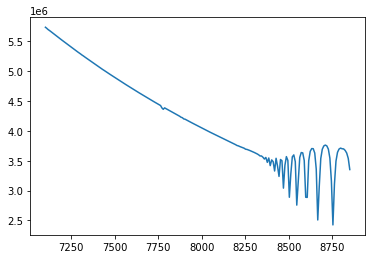

In [127]:
plt.plot(waveL, fluxOL)

In [136]:
nsflux = []
N=1000
for i in range(N):
    ssobs = getObs(ssc,skym,0, nlarr[0])
    fluxL = resampleSpec(ssobs[dx:],20)
    fluxL = fluxL[iwmL]
    nsflux.append(fluxL)
nsflux = np.vstack(nsflux)

SN = int(np.around(getSN(ssobs),-1))
nsflux.shape, fluxOL.shape, SN
#     plt.figure(figsize=(16,6))
#     plt.plot(wwm[iwm],ssobs[iwm],lw=0.2)
#     plt.plot(wwm[iwm],ssm[iwm],lw=1)
#     plt.show()

((1000, 221), (221,), 10)

In [137]:
save_nsflux(waveL, fluxOL, nsflux, SN, N,R="BHB")

In [111]:
def save_nsflux(wave, flux, nsflux, SN, N, R="BHB"):
    nn = N // 1000
    PATH = f"/scratch/ceph/swei20/data/dnn/{R}/snr{SN}_{nn}k.h5"
    with h5py.File(PATH, "w") as f:
        f.create_dataset(f"nsflux_R", data=nsflux, shape=nsflux.shape)
        f.create_dataset(f"flux_R", data=flux, shape=flux.shape)
        f.create_dataset(f"wave_R", data=wave, shape=wave.shape)

#     f.create_dataset(f"lbl{ww}", data=lbls, shape=lbls.shape)
#     f.create_dataset(f"para{ww}", data=paras, shape=paras.shape)

In [53]:
wwm[iwm]

array([7100.24199931, 7100.59719931, 7100.95211929, ..., 8848.77011914,
       8849.21249903, 8849.65525905])

In [30]:
len(wwm), len(wwm[iwm])

(8893, 4406)

In [27]:
len(ssobs)

8893

In [35]:
resampleWave(wwm[iwm], 20).shape

(220,)

In [ ]:
W="RML"
DATA_PATH = f"/scratch/ceph/szalay/swei20/AE/norm_flux_{W}_R1000.h5"
with h5py.File(DATA_PATH, 'r') as f:
    flux = f['flux'][()]
    para = f['para'][()]
    wave = f['wave'][()]